Begin: July 13 2019   
Author: Rhondene Wint
## Introduction:

This notebook is pursuing questions that my advisor Dr. David Ardell put forth after we discussed my intial work and literature review that shed light on the prevalence of tRNA genes that are nested in the introns of protein coding genes of Drosophila melanogaster. As a follow-up, Dave proposed 7 questions. I will address the first 3 questions which are stated in the objectives below.

## Objectives
- How many genes host tRNAs in their introns?
- How do length and nucleotide composition of nested and non-nested tRNA genes compare?
- Compare the composition of nested tRNAs and their host introns (I will extend to host protein-coding). Do nested genes reflect the composition of  their host introns or just introns in general?

## Data:
- I am using the most current Flybase release 6.27 annotations of Drosophila genes

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn
import scipy.stats as stats

## How many genes host tRNAs in their introns

I answered this question in previous work. To summarise:
- To obtain the parent genes that host tRNAs: using bed files I queried the tRNA genomic coordinates against coordinates of introns of all non-tRNA genes on the same chromosome, selecting for trnas that are a subset of the non-tRNA genes. 
- I uploaded the list of parent host genes to the Flybase feature mapper that returns genomic features whose coordinates are a subset of the query genes .
- I used the flybase feature mapper to download a merged gff3 tables containing only tRNAs that are subfeatures of the list of query genes. I modified the gff3 file to add a few additional information that i previously computed such as the host gene strand wrt to the underlying chromosome

In [4]:
##load the merged gff3 file
merged = pd.read_table('trna_host_genes_merged.csv', sep=',')
merged.head()

,Chrom,Start,End,Strand,tRNA_ID,tRNA_name,Host_Exon_ID,intron_length,mRNA_length,Host_gene_name,...,A-content,G-content,T-content,C-content,tRNA_Sequence,A-content_trna,G-content_trna,T-content_trna,C-content_trna,Anticodon
0,3L,13249547,13249618,+,FBgn0011844,Asp-GTC-1-10-,FBtr0305480,12439,4841,caps,...,0.282901,0.208779,0.291181,0.217140,UCCUCGAUAGUAUAGUGGUUAGUAUCCCCGCCUGUCACGCGGGAGA...,0.166667,0.319444,0.236111,0.277778,GTC
1,3R,24555302,24555373,+,FBgn0011845,Asp-GTC-1-11-,FBtr0084647,325,3120,Esyt2,...,0.286154,0.172308,0.350769,0.190769,UCCUCGAUAGUAUAGUGGUUAGUAUCCCCGCCUGUCACGCGGGAGA...,0.166667,0.319444,0.236111,0.277778,GTC
2,3L,1397695,1397766,+,FBgn0011851,Glu-CTC-3-4-,FBtr0310161,126467,5167,Ptp61F,...,0.268979,0.226012,0.280136,0.224873,UCCCAUAUUGUCUAGUGGUUAGGAUAUCCGGCUCUCACCCGGAAGG...,0.194444,0.277778,0.263889,0.263889,CTC
3,3L,1397932,1398003,+,FBgn0011852,Glu-CTC-3-5-,FBtr0310161,126467,5167,Ptp61F,...,0.268979,0.226012,0.280136,0.224873,UCCCAUAUUGUCUAGUGGUUAGGAUAUCCGGCUCUCACCCGGAAGG...,0.194444,0.277778,0.263889,0.263889,CTC
4,3L,1398169,1398240,+,FBgn0011853,Glu-CTC-3-6-,FBtr0310161,126467,5167,Ptp61F,...,0.268979,0.226012,0.280136,0.224873,UCCCAUAUUGUCUAGUGGUUAGGAUAUCCGGCUCUCACCCGGAAGG...,0.194444,0.277778,0.263889,0.263889,CTC


In [6]:
print('Number of genes hosting tRNAs is: ',merged['Host_gene_name'].unique().shape[0], 'genes')

Number of genes hosting tRNAs is:  65 genes


In [7]:
##plot the number of tRNA genes in each host gene,copied code from an older notebook
gene_group = merged.groupby('Host_gene_name')
genes = merged['Host_gene_name'].unique()
##store the number of trnas for eachgene
num_trna = dict()
for g in genes:
    num = gene_group.get_group(g).shape[0] #number of rowns correspond to th number of trnas
    trnas = list(gene_group.get_group(g)['tRNA_ID'].values)
    num_trna[g]=[num,trnas]
df_counts = pd.DataFrame.from_dict(num_trna, orient='index').reset_index()
df_counts.columns = ['Gene', 'Num_of_tRNAs', 'tRNA_IDs']
df_counts.head() 

,Gene,Num_of_tRNAs,tRNA_IDs
0,caps,1,[FBgn0011844]
1,Esyt2,1,[FBgn0011845]
2,Ptp61F,9,"[FBgn0011851, FBgn0011852, FBgn0011853, FBgn00..."
3,Sulf1,2,"[FBgn0011858, FBgn0012011]"
4,Wdr62,1,[FBgn0011859]


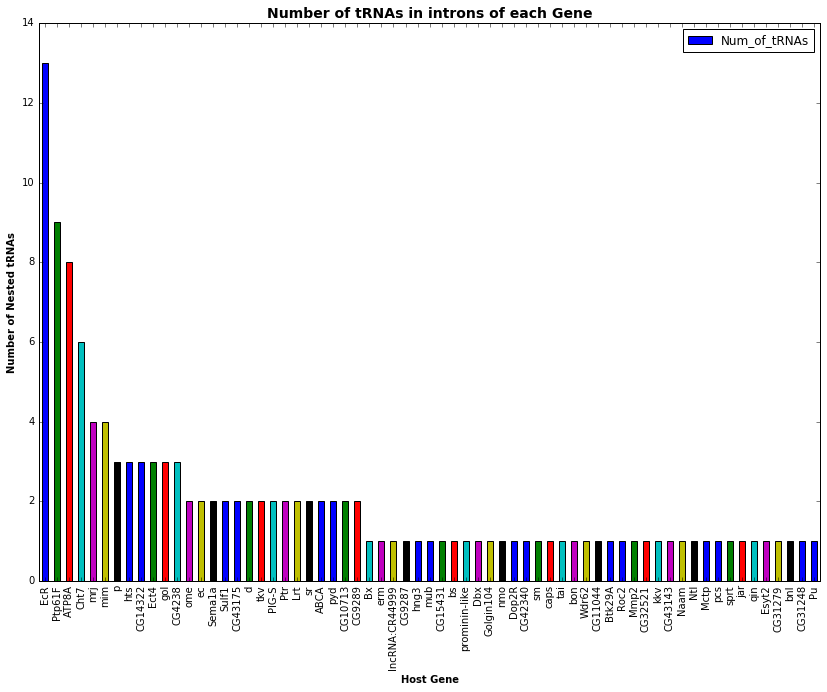

In [12]:
df_counts.sort_values(by='Num_of_tRNAs', ascending=False).plot.bar('Gene', 'Num_of_tRNAs', figsize=(14,10))
plt.title('Number of tRNAs in introns of each Gene', fontsize=14, fontweight='bold')
plt.xlabel('Host Gene', fontweight='bold')
plt.ylabel('Number of Nested tRNAs', fontweight='bold')
plt.show()

In [9]:
##number of host genes with trna clusters
df_counts[df_counts['Num_of_tRNAs']>1].shape[0]

27

In [14]:
from scipy.stats import mstats
import probscale

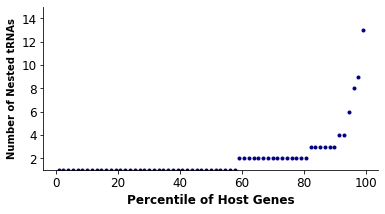

In [28]:
###plot percentile scale
position, bill = probscale.plot_pos(df_counts['Num_of_tRNAs'])
position *= 100
fig, ax = plt.subplots(figsize=(6, 3))
ax.plot(position, bill, marker='.', linestyle='none', label='Bill amount',color='navy')
ax.set_xlabel('Percentile of Host Genes',fontsize=12, fontweight='bold')
ax.set_ylabel('Number of Nested tRNAs',fontweight='bold')
plt.xticks(fontsize=12); plt.yticks(fontsize=12)
#ax.set_yscale('log')
ax.set_ylim(bottom=1, top=15)
seaborn.despine()

In [35]:
##get ids of genes with multiple trnas
df_counts[df_counts['Num_of_tRNAs']>1]['Gene'].to_csv('./GO_analysis/cluster_2_hosts.csv',sep=',', header=None,index=False)
df_counts[df_counts['Num_of_tRNAs']>=4]['Gene'].to_csv('./GO_analysis/cluster_4_hosts.csv',sep=',', header=None,index=False)


c:\users\rwint\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  
c:\users\rwint\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  This is separate from the ipykernel package so we can avoid doing imports until


In [38]:
df_counts[df_counts['Num_of_tRNAs']>=2]['Gene'].values

array(['Ptp61F', 'Sulf1', 'EcR', 'ATP8A', 'mim', 'ome', 'Ptr', 'pyd',
       'CG10713', 'p', 'ec', 'hts', 'Lrt', 'gol', 'mrj', 'sr', 'PIG-S',
       'CG43175', 'CG14322', 'Sema1a', 'CG4238', 'CG9289', 'd', 'tkv',
       'Cht7', 'Ect4', 'ABCA'], dtype=object)

## Question 2: How do length and nucleotide composition of nested and non-nested tRNA genes compare?

#### Approach:
- Starting with the whole tRNA sequence fasta file, categorise the tRNA sequences into their on fasta file based on "Nested", "Non-Nested", "Nested-Sense", "Nested-Antisense".
- Compute and compare nucleotide composition: G%, A%, T%, C%, GC% and AT-content

In [15]:
##extract the tRNA gene IDs of all the nested tRNAs
nested_IDs = merged['tRNA_ID'].values
nested_IDs.shape

(130,)

In [19]:
nested_IDs[0]

'FBgn0011844'

In [17]:
## look athe whole trna sequences
!head -2 dmel-all-tRNA-r6.27.fasta

>FBtr0070001 type=tRNA; loc=X:20025099..20025170; ID=FBtr0070001; name=tRNA:Pro-CGG-1-1-RA; dbxref=FlyBase:FBtr0070001,FlyBase_Annotation_IDs:CR32826-RA,RNAcentral:URS00000C18F2_7227; MD5=376f4e117637d6ac68f3a5d7195ff7be; length=72; parent=FBgn0052826; release=r6.27; species=Dmel; 
GGCTCGTTGGTCTAGGGGTATGATTCTCGCTTCGGGTGCGAGAGGTCCCGGGTTCAAATCCCGGACGAGCCC


I remembered that I have a customised dmel flybase tRNA database that made when I initially started last year fall, with sequences and all

In [2]:
fb_trna = pd.read_table('dmel_fb_trna.csv',sep=',')
fb_trna.head()

,Flybase_ID,Fb_symbol,Chromosome,Start,End,Sequence,Complement,Amino_acid
0,FBgn0011840,Ala-AGC-2-3,3R,17620144,17620216,GGGGAUGUAGCUCAGAUGGUAGAGCGCUCGCUUAGCAUGUGAGAGG...,True,Glu
1,FBgn0011844,Asp-GTC-1-10,3L,13249547,13249618,UCCUCGAUAGUAUAGUGGUUAGUAUCCCCGCCUGUCACGCGGGAGA...,False,Lys
2,FBgn0011845,Asp-GTC-1-11,3R,24555302,24555373,UCCUCGAUAGUAUAGUGGUUAGUAUCCCCGCCUGUCACGCGGGAGA...,False,Gly
3,FBgn0011848,Glu-TTC-1-6,2R,19727981,19728052,UCCCAUAUGGUCUAGUGGCUAGGAUAUCUGGCUUUCACCCAGAAGG...,True,Gly
4,FBgn0011849,Glu-TTC-1-5,2R,19727460,19727531,UCCCAUAUGGUCUAGUGGCUAGGAUAUCUGGCUUUCACCCAGAAGG...,True,Phe


###fix aa

In [6]:
aa = []
for name in fb_trna['Fb_symbol'].values:
    aa.append(name[0:3])
aa[:4]
fb_trna['Amino_acid'] = aa

In [21]:
fb_trna.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 288 entries, 0 to 287
Data columns (total 8 columns):
Flybase_ID    288 non-null object
Fb_symbol     288 non-null object
Chromosome    288 non-null object
Start         288 non-null int64
End           288 non-null int64
Sequence      288 non-null object
Complement    288 non-null bool
Amino_acid    288 non-null object
dtypes: bool(1), int64(2), object(5)
memory usage: 16.1+ KB


In [23]:
##check that IDs are consistent in both tables
fb_trna[fb_trna['Flybase_ID']==merged['tRNA_ID'].values[0]]

,Flybase_ID,Fb_symbol,Chromosome,Start,End,Sequence,Complement,Amino_acid
1,FBgn0011844,Asp-GTC-1-10,3L,13249547,13249618,UCCUCGAUAGUAUAGUGGUUAGUAUCCCCGCCUGUCACGCGGGAGA...,False,Lys


In [26]:
merged.head(1) ## oh yeah the A in Asp and Ala are truncaed, though I fixed that

,Chrom,Start,End,Strand,tRNA_ID,tRNA_name,Host_Exon_ID,intron_length,mRNA_length,Host_gene_name,Host_Gene_Strand,Co-orientation
0,3L,13249547,13249618,+,FBgn0011844,sp-GTC-1-10-,FBtr0305480,49756,4841,caps,+,Yes


In [33]:
## tRNA IDs should be a subset of the total flybase tRNA annotation
for ID in merged['tRNA_ID'].values:
    if ID not in fb_trna['Flybase_ID'].values:
        print(ID)

In [39]:
##I also have a gtf file with all tRNAs
trna_gtf = pd.read_table('dmel-all_trnasr6.27_cleaned.gtf',sep='\t')
trna_gtf.head()

,Chr,Database,Feature,Start,End,?,Strand,?.1,Header
0,X,FlyBase,tRNA,20025099,20025170,.,+,.,FBtr0070001:Pro-CGG-1-1;
1,X,FlyBase,tRNA,3427452,3427523,.,-,.,FBtr0070533:Gln-TTG-2-1;
2,X,FlyBase,tRNA,3819699,3819770,.,+,.,FBtr0070603:Gln-CTG-2-1;
3,X,FlyBase,tRNA,3827622,3827693,.,+,.,FBtr0070604:Pro-CGG-3-1;
4,X,FlyBase,tRNA,6516974,6517046,.,+,.,FBtr0070911:Phe-GAA-1-1;


1. divide trnas into nested and non-nested

In [40]:
fb_trna.columns

Index(['Flybase_ID', 'Fb_symbol', 'Chromosome', 'Start', 'End', 'Sequence',
       'Complement', 'Amino_acid'],
      dtype='object')

In [43]:
##label the trnas as nested or non nested
l = []
for ID in fb_trna['Flybase_ID'].values:
    if ID in merged['tRNA_ID'].values:
        l.append('Nested')
    else:
        l.append('Non-Nested')
fb_trna['Organization'] = l
fb_trna.head()

,Flybase_ID,Fb_symbol,Chromosome,Start,End,Sequence,Complement,Amino_acid,Organization
0,FBgn0011840,Ala-AGC-2-3,3R,17620144,17620216,GGGGAUGUAGCUCAGAUGGUAGAGCGCUCGCUUAGCAUGUGAGAGG...,True,Glu,Non-Nested
1,FBgn0011844,Asp-GTC-1-10,3L,13249547,13249618,UCCUCGAUAGUAUAGUGGUUAGUAUCCCCGCCUGUCACGCGGGAGA...,False,Lys,Nested
2,FBgn0011845,Asp-GTC-1-11,3R,24555302,24555373,UCCUCGAUAGUAUAGUGGUUAGUAUCCCCGCCUGUCACGCGGGAGA...,False,Gly,Nested
3,FBgn0011848,Glu-TTC-1-6,2R,19727981,19728052,UCCCAUAUGGUCUAGUGGCUAGGAUAUCUGGCUUUCACCCAGAAGG...,True,Gly,Non-Nested
4,FBgn0011849,Glu-TTC-1-5,2R,19727460,19727531,UCCCAUAUGGUCUAGUGGCUAGGAUAUCUGGCUUUCACCCAGAAGG...,True,Phe,Non-Nested


In [44]:
##check that the number of trnas labelled nested is same the original 130 nested tRNAs
fb_trna['Organization'].value_counts()

Non-Nested    158
Nested        130
Name: Organization, dtype: int64

### write nesteed and non-nested sequences to a fasta file

In [45]:
nested_trnas = fb_trna[fb_trna['Organization']=='Nested']
non_nested= fb_trna[fb_trna['Organization']!='Nested']

In [47]:
nested_trnas['Sequence'].values[0]

'UCCUCGAUAGUAUAGUGGUUAGUAUCCCCGCCUGUCACGCGGGAGACCGGGGUUCAAUUCCCCGUCGGGGAG'

In [48]:
with open('nested_trnas.fasta', 'w') as f:
    for i in range(nested_trnas.shape[0]):
        header = '>{}:{}'.format(nested_trnas['Flybase_ID'].values[i], nested_trnas['Fb_symbol'].values[i])
        seq = nested_trnas['Sequence'].values[i]
        f.write(header+'\n'+seq+'\n')

In [49]:
!head nested_trnas.fasta

>FBgn0011844:Asp-GTC-1-10
UCCUCGAUAGUAUAGUGGUUAGUAUCCCCGCCUGUCACGCGGGAGACCGGGGUUCAAUUCCCCGUCGGGGAG
>FBgn0011845:Asp-GTC-1-11
UCCUCGAUAGUAUAGUGGUUAGUAUCCCCGCCUGUCACGCGGGAGACCGGGGUUCAAUUCCCCGUCGGGGAG
>FBgn0011851:Glu-CTC-3-4
UCCCAUAUUGUCUAGUGGUUAGGAUAUCCGGCUCUCACCCGGAAGGCCCGGGUUCAAUUCCCGGUAUGGGAA
>FBgn0011852:Glu-CTC-3-5
UCCCAUAUUGUCUAGUGGUUAGGAUAUCCGGCUCUCACCCGGAAGGCCCGGGUUCAAUUCCCGGUAUGGGAA
>FBgn0011853:Glu-CTC-3-6
UCCCAUAUUGUCUAGUGGUUAGGAUAUCCGGCUCUCACCCGGAAGGCCCGGGUUCAAUUCCCGGUAUGGGAA


In [51]:
with open('non_nested_trnas.fasta', 'w') as f:
    for i in range(non_nested.shape[0]):
        header = '>{}:{}'.format(non_nested['Flybase_ID'].values[i], non_nested['Fb_symbol'].values[i])
        seq = non_nested['Sequence'].values[i]
        f.write(header+'\n'+seq+'\n')
!head non_nested_trnas.fasta    

>FBgn0011840:Ala-AGC-2-3
GGGGAUGUAGCUCAGAUGGUAGAGCGCUCGCUUAGCAUGUGAGAGGUACGGGGAUCGAUGCCCCGCAUCUCCA
>FBgn0011848:Glu-TTC-1-6
UCCCAUAUGGUCUAGUGGCUAGGAUAUCUGGCUUUCACCCAGAAGGCCCGGGUUCGAUUCCCGGUAUGGGAA
>FBgn0011849:Glu-TTC-1-5
UCCCAUAUGGUCUAGUGGCUAGGAUAUCUGGCUUUCACCCAGAAGGCCCGGGUUCGAUUCCCGGUAUGGGAA
>FBgn0011850:Glu-TTC-1-4
UCCCAUAUGGUCUAGUGGCUAGGAUAUCUGGCUUUCACCCAGAAGGCCCGGGUUCGAUUCCCGGUAUGGGAA
>FBgn0011860:Gly-GCC-1-2
GCAUCGGUGGUUCAGUGGUAGAAUGCUCGCCUGCCACGCGGGCGGCCCGGGUUCGAUUCCCGGCCGAUGCA


### 2. label the fb_trna that nested-sense, nested-anti-sense, non-nested

- Previously I categorised the nested genes that are co-oriented with thier host genes. By co-orientation, I mean that both host and nested genes are annotated with the same strandededness relative the underlying chromosome. 

In [53]:
merged.head()  ##co-orientation column

,Chrom,Start,End,Strand,tRNA_ID,tRNA_name,Host_Exon_ID,intron_length,mRNA_length,Host_gene_name,Host_Gene_Strand,Co-orientation
0,3L,13249547,13249618,+,FBgn0011844,sp-GTC-1-10-,FBtr0305480,49756,4841,caps,+,Yes
1,3R,24555302,24555373,+,FBgn0011845,sp-GTC-1-11-,FBtr0084647,1309,3120,Esyt2,+,Yes
2,3L,1397695,1397766,+,FBgn0011851,Glu-CTC-3-4-,FBtr0310161,204807,5167,Ptp61F,-,No
3,3L,1397932,1398003,+,FBgn0011852,Glu-CTC-3-5-,FBtr0310161,204807,5167,Ptp61F,-,No
4,3L,1398169,1398240,+,FBgn0011853,Glu-CTC-3-6-,FBtr0310161,204807,5167,Ptp61F,-,No


In [55]:
cooriented = pd.read_table('cooriented_genes.csv',sep=',') #subset of sense nested tRNAs
cooriented.head()

,Chrom,Start,End,Strand,tRNA_ID,tRNA_name,Host_Exon_ID,intron_length,mRNA_length,Host_gene_name,Host_Gene_Strand,Co-orientation
0,3L,13249547,13249618,+,FBgn0011844,sp-GTC-1-10-,FBtr0305480,49756,4841,caps,+,Yes
1,3R,24555302,24555373,+,FBgn0011845,sp-GTC-1-11-,FBtr0084647,1309,3120,Esyt2,+,Yes
2,2R,20232797,20232867,+,FBgn0011870,Gly-GCC-1-11-,FBtr0086313,695,2041,CG11044,+,Yes
3,2R,6164876,6164948,-,FBgn0011888,Lys-CTT-1-3-,FBtr0086008,16205,5108,EcR,-,Yes
4,2R,6162681,6162753,-,FBgn0011889,Lys-CTT-1-2-,FBtr0086008,16205,5108,EcR,-,Yes


In [56]:
l = []
for ID in fb_trna['Flybase_ID'].values:
    if ID in merged['tRNA_ID'].values:
        ##then query the sense nested tRNAs
        if ID in cooriented['tRNA_ID'].values:
            l.append('Nested-Sense')
        else:
            l.append('Nested-Antisense')
    else:
        l.append('Non-nested')
fb_trna['Co-orienation'] = l
fb_trna.head()

,Flybase_ID,Fb_symbol,Chromosome,Start,End,Sequence,Complement,Amino_acid,Organization,Co-orienation
0,FBgn0011840,Ala-AGC-2-3,3R,17620144,17620216,GGGGAUGUAGCUCAGAUGGUAGAGCGCUCGCUUAGCAUGUGAGAGG...,True,Glu,Non-Nested,Non-nested
1,FBgn0011844,Asp-GTC-1-10,3L,13249547,13249618,UCCUCGAUAGUAUAGUGGUUAGUAUCCCCGCCUGUCACGCGGGAGA...,False,Lys,Nested,Nested-Sense
2,FBgn0011845,Asp-GTC-1-11,3R,24555302,24555373,UCCUCGAUAGUAUAGUGGUUAGUAUCCCCGCCUGUCACGCGGGAGA...,False,Gly,Nested,Nested-Sense
3,FBgn0011848,Glu-TTC-1-6,2R,19727981,19728052,UCCCAUAUGGUCUAGUGGCUAGGAUAUCUGGCUUUCACCCAGAAGG...,True,Gly,Non-Nested,Non-nested
4,FBgn0011849,Glu-TTC-1-5,2R,19727460,19727531,UCCCAUAUGGUCUAGUGGCUAGGAUAUCUGGCUUUCACCCAGAAGG...,True,Phe,Non-Nested,Non-nested


### 3. write sense and antisense sequences to separate fasta file

In [57]:
sense = fb_trna[fb_trna['Co-orienation']=='Nested-Sense']
antisense = fb_trna[fb_trna['Co-orienation']=='Nested-Antisense']

In [58]:
with open('sense_nested_trnas.fasta', 'w') as f:
    for i in range(sense.shape[0]):
        header = '>{}:{}'.format(sense['Flybase_ID'].values[i], sense['Fb_symbol'].values[i])
        seq = sense['Sequence'].values[i]
        f.write(header+'\n'+seq+'\n')

        
with open('antisense_nested_trnas.fasta', 'w') as f:
    for i in range(antisense.shape[0]):
        header = '>{}:{}'.format(antisense['Flybase_ID'].values[i], antisense['Fb_symbol'].values[i])
        seq = antisense['Sequence'].values[i]
        f.write(header+'\n'+seq+'\n')
 

### 4. compute and compare nucleotide composition of nested and non-nested and store it

In [60]:
'cat'.count('a')

1

In [73]:
def base_comp(seqs,base):
    """computes base/nucleotide composition
    Input: 
    seqs: array or list of sequences
    base: char, nucleotide A,C,G, or T
    Output: returns list of base compoisiton"""
    content = []
    for seq in seqs:
        fraction = seq.upper().replace('U','T').count(base.upper())/len(seq)  ##replace U with T
        content.append(fraction)
    assert len(content) == len(seqs)
    return content

In [74]:
##append content to fb_trna
for base in ['A','G','C','T']:
    fb_trna['{}-content'.format(base)] = base_comp(fb_trna['Sequence'].values,base)

In [75]:
fb_trna.head()

,Flybase_ID,Fb_symbol,Chromosome,Start,End,Sequence,Complement,Amino_acid,Organization,Co-orienation,A-content,G-content,C-content,T-content
0,FBgn0011840,Ala-AGC-2-3,3R,17620144,17620216,GGGGAUGUAGCUCAGAUGGUAGAGCGCUCGCUUAGCAUGUGAGAGG...,True,Glu,Non-Nested,Non-nested,0.205479,0.356164,0.232877,0.205479
1,FBgn0011844,Asp-GTC-1-10,3L,13249547,13249618,UCCUCGAUAGUAUAGUGGUUAGUAUCCCCGCCUGUCACGCGGGAGA...,False,Lys,Nested,Nested-Sense,0.166667,0.319444,0.277778,0.236111
2,FBgn0011845,Asp-GTC-1-11,3R,24555302,24555373,UCCUCGAUAGUAUAGUGGUUAGUAUCCCCGCCUGUCACGCGGGAGA...,False,Gly,Nested,Nested-Sense,0.166667,0.319444,0.277778,0.236111
3,FBgn0011848,Glu-TTC-1-6,2R,19727981,19728052,UCCCAUAUGGUCUAGUGGCUAGGAUAUCUGGCUUUCACCCAGAAGG...,True,Gly,Non-Nested,Non-nested,0.194444,0.291667,0.250000,0.263889
4,FBgn0011849,Glu-TTC-1-5,2R,19727460,19727531,UCCCAUAUGGUCUAGUGGCUAGGAUAUCUGGCUUUCACCCAGAAGG...,True,Phe,Non-Nested,Non-nested,0.194444,0.291667,0.250000,0.263889


In [77]:
##Compute GC and AT content
fb_trna['GC-content'] = fb_trna['G-content']+fb_trna['C-content']
fb_trna['AT-content'] = fb_trna['C-content']+fb_trna['T-content']

In [78]:
fb_trna.head()

,Flybase_ID,Fb_symbol,Chromosome,Start,End,Sequence,Complement,Amino_acid,Organization,Co-orienation,A-content,G-content,C-content,T-content,GC-content,AT-content
0,FBgn0011840,Ala-AGC-2-3,3R,17620144,17620216,GGGGAUGUAGCUCAGAUGGUAGAGCGCUCGCUUAGCAUGUGAGAGG...,True,Glu,Non-Nested,Non-nested,0.205479,0.356164,0.232877,0.205479,0.589041,0.438356
1,FBgn0011844,Asp-GTC-1-10,3L,13249547,13249618,UCCUCGAUAGUAUAGUGGUUAGUAUCCCCGCCUGUCACGCGGGAGA...,False,Lys,Nested,Nested-Sense,0.166667,0.319444,0.277778,0.236111,0.597222,0.513889
2,FBgn0011845,Asp-GTC-1-11,3R,24555302,24555373,UCCUCGAUAGUAUAGUGGUUAGUAUCCCCGCCUGUCACGCGGGAGA...,False,Gly,Nested,Nested-Sense,0.166667,0.319444,0.277778,0.236111,0.597222,0.513889
3,FBgn0011848,Glu-TTC-1-6,2R,19727981,19728052,UCCCAUAUGGUCUAGUGGCUAGGAUAUCUGGCUUUCACCCAGAAGG...,True,Gly,Non-Nested,Non-nested,0.194444,0.291667,0.250000,0.263889,0.541667,0.513889
4,FBgn0011849,Glu-TTC-1-5,2R,19727460,19727531,UCCCAUAUGGUCUAGUGGCUAGGAUAUCUGGCUUUCACCCAGAAGG...,True,Phe,Non-Nested,Non-nested,0.194444,0.291667,0.250000,0.263889,0.541667,0.513889


In [82]:
##store lengths
l=[]
for seq in fb_trna['Sequence'].values:
    l.append(len(seq))
fb_trna['Length']= l

In [7]:
##save this updated table
fb_trna.to_csv('complete_trna_info.csv',sep=',',index=False)

#### count the number of trnas in each category of organization

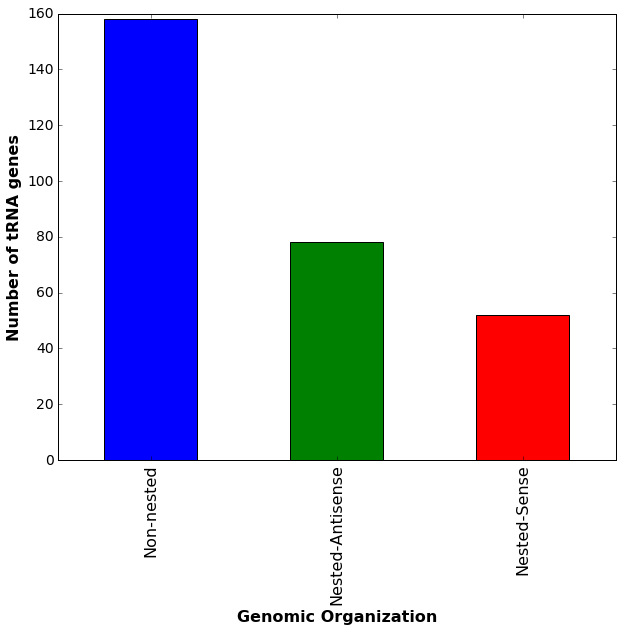

In [176]:
fb_trna['Co-orientation'].value_counts().to_frame().reset_index().plot.bar('index',0,legend=False,figsize=(10,8))
plt.ylabel('Number of tRNA genes', fontsize=16, fontweight='bold')
plt.xlabel('Genomic Organization', fontsize=16, fontweight='bold')
plt.yticks(fontsize=14);plt.xticks(fontsize=16)
plt.
plt.savefig('trna_organization.png')
plt.show()

In [171]:
##STATS SUMMARY
fb_trna[fb_trna['Co-orientation']=='Nested-Sense'].describe()

,Start,End,A-content,G-content,C-content,T-content,GC-content,AT-content,Length
count,5.200000e+01,5.200000e+01,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000
mean,1.162219e+07,1.162226e+07,0.184558,0.327906,0.258396,0.229140,0.586301,0.487536,76.250000
std,6.651486e+06,6.651485e+06,0.039454,0.028910,0.026372,0.024544,0.045480,0.028140,10.617919
min,7.437230e+05,7.437940e+05,0.125000,0.263889,0.180851,0.166667,0.468085,0.425532,71.000000
25%,6.164327e+06,6.164399e+06,0.164384,0.315609,0.247917,0.219178,0.575342,0.472785,72.000000
50%,8.668846e+06,8.668940e+06,0.166667,0.331050,0.263889,0.229730,0.597222,0.493151,73.000000
75%,1.765991e+07,1.765998e+07,0.206193,0.342466,0.274924,0.244932,0.616438,0.513889,74.000000
max,2.491506e+07,2.491513e+07,0.287234,0.378378,0.309859,0.277778,0.676056,0.527778,120.000000


In [172]:
fb_trna[fb_trna['Co-orientation']=='Non-nested'].describe()

,Start,End,A-content,G-content,C-content,T-content,GC-content,AT-content,Length
count,1.580000e+02,1.580000e+02,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000
mean,1.398580e+07,1.398587e+07,0.188009,0.325214,0.257066,0.229711,0.582279,0.486777,75.879747
std,6.353098e+06,6.353097e+06,0.033130,0.029171,0.025291,0.025345,0.044776,0.023634,8.169664
min,7.695030e+05,7.696000e+05,0.126761,0.250000,0.191489,0.166667,0.458333,0.419355,71.000000
25%,8.140539e+06,8.140611e+06,0.166667,0.309086,0.246575,0.219178,0.561644,0.472222,72.000000
50%,1.408700e+07,1.408708e+07,0.191781,0.328767,0.256098,0.227768,0.585366,0.487805,73.000000
75%,1.863968e+07,1.863975e+07,0.205479,0.342466,0.273973,0.245907,0.602740,0.506994,74.000000
max,3.024862e+07,3.024870e+07,0.290323,0.378378,0.309859,0.305556,0.676056,0.527778,120.000000


In [173]:
fb_trna[fb_trna['Co-orientation']=='Nested-Antisense'].describe()

,Start,End,A-content,G-content,C-content,T-content,GC-content,AT-content,Length
count,7.800000e+01,7.800000e+01,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000,78.000000
mean,1.076077e+07,1.076084e+07,0.191796,0.317243,0.259592,0.231369,0.576835,0.490961,74.756410
std,7.411488e+06,7.411489e+06,0.027270,0.030122,0.022600,0.026869,0.038452,0.026386,7.233016
min,1.379934e+06,1.380005e+06,0.126761,0.250000,0.194444,0.166667,0.472222,0.430556,71.000000
25%,3.880780e+06,3.880852e+06,0.178701,0.291667,0.246575,0.208333,0.549848,0.472222,72.000000
50%,8.772666e+06,8.772737e+06,0.191781,0.319444,0.263889,0.229730,0.583333,0.493151,73.000000
75%,1.634286e+07,1.634293e+07,0.205479,0.333333,0.272925,0.253012,0.596726,0.512177,74.000000
max,2.507705e+07,2.507712e+07,0.259259,0.378378,0.309859,0.291667,0.676056,0.527778,120.000000


## Visualise base compositions and lengths distributions

#### I want all the nuc_composition onf the same axis thoug

In [97]:
fb_trna.columns

Index(['Flybase_ID', 'Fb_symbol', 'Chromosome', 'Start', 'End', 'Sequence',
       'Complement', 'Amino_acid', 'Organization', 'Co-orienation',
       'A-content', 'G-content', 'C-content', 'T-content', 'GC-content',
       'AT-content', 'Length'],
      dtype='object')

In [98]:
##correct the spelling
fb_trna['Co-orientation']=fb_trna['Co-orienation']
fb_trna.drop('Co-orienation',axis=1, inplace=True)
##save this updated table
fb_trna.to_csv('complete_trna_info.csv',sep=',',index=False)

In [178]:
df = fb_trna[['Organization','A-content', 'G-content', 'C-content','T-content']].head()

In [108]:
data=pd.melt(fb_trna,id_vars=['Organization'],value_vars=['A-content', 'G-content', 'C-content','T-content'],
             var_name='Nucleotide/Base')
data.head()

,Organization,Nucleotide/Base,value
0,Non-Nested,A-content,0.205479
1,Nested,A-content,0.166667
2,Nested,A-content,0.166667
3,Non-Nested,A-content,0.194444
4,Non-Nested,A-content,0.194444


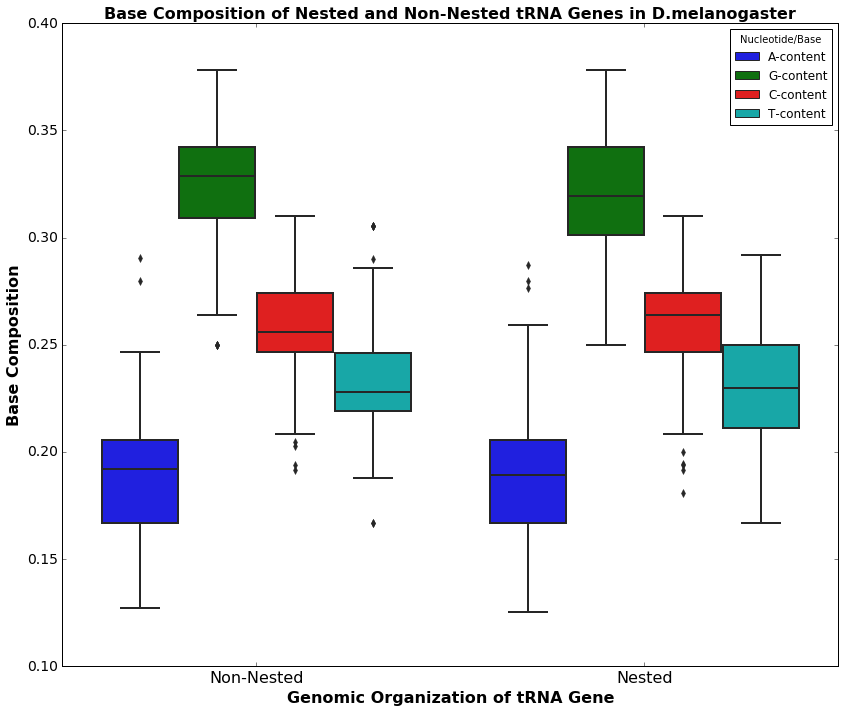

In [126]:
data=pd.melt(fb_trna,id_vars=['Organization'],value_vars=['A-content', 'G-content', 'C-content','T-content'],
             var_name='Nucleotide/Base')
plt.figure(figsize=(12,10))
ax = seaborn.boxplot(x='Organization',y='value',data=data,hue='Nucleotide/Base',width=0.8,linewidth=2)
plt.xticks(fontsize=16);plt.yticks(fontsize=14)
plt.ylabel('Base Composition',fontsize=16, fontweight='bold')
plt.xlabel('Genomic Organization of tRNA Gene',fontsize=16, fontweight='bold')
plt.title('Base Composition of Nested and Non-Nested tRNA Genes in D.melanogaster',fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

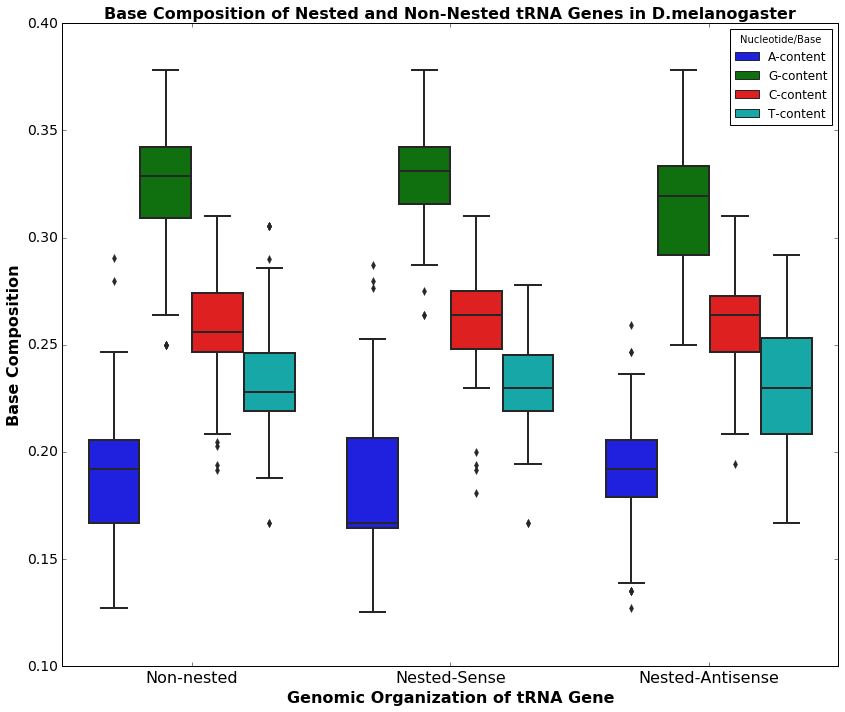

In [139]:
data=pd.melt(fb_trna,id_vars=['Co-orientation'],value_vars=['A-content', 'G-content', 'C-content','T-content'],
             var_name='Nucleotide/Base')
plt.figure(figsize=(12,10))
ax = seaborn.boxplot(x='Co-orientation',y='value',data=data,hue='Nucleotide/Base',width=0.8,linewidth=2)
#ax = seaborn.violinplot(x='Co-orientation',y='value',data=data,hue='Nucleotide/Base',width=0.8,linewidth=2,saturation=0.3)
plt.xticks(fontsize=16);plt.yticks(fontsize=14)
plt.ylabel('Base Composition',fontsize=16, fontweight='bold')
plt.xlabel('Genomic Organization of tRNA Gene',fontsize=16, fontweight='bold')
plt.title('Base Composition of Nested and Non-Nested tRNA Genes in D.melanogaster',fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

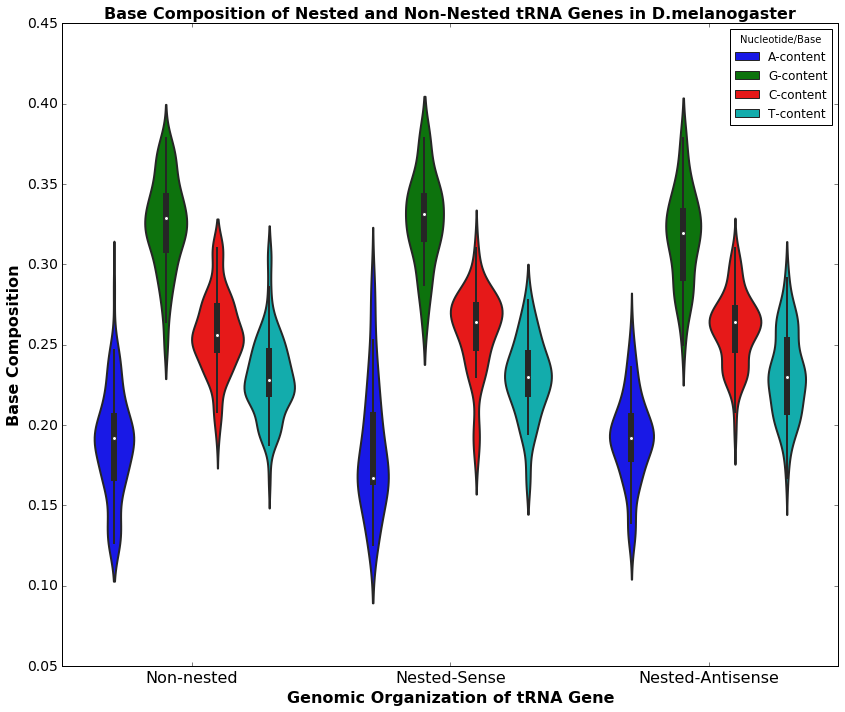

In [150]:
data=pd.melt(fb_trna,id_vars=['Co-orientation'],value_vars=['A-content', 'G-content', 'C-content','T-content'],
             var_name='Nucleotide/Base')
plt.figure(figsize=(12,10))
#ax = seaborn.boxplot(x='Co-orientation',y='value',data=data,hue='Nucleotide/Base',width=0.8,linewidth=2)
viol = seaborn.violinplot(x='Co-orientation',y='value',data=data,hue='Nucleotide/Base',width=0.8,linewidth=2,saturation=0.8)
plt.xticks(fontsize=16);plt.yticks(fontsize=14)
plt.ylabel('Base Composition',fontsize=16, fontweight='bold')
plt.xlabel('Genomic Organization of tRNA Gene',fontsize=16, fontweight='bold')
plt.title('Base Composition of Nested and Non-Nested tRNA Genes in D.melanogaster',fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

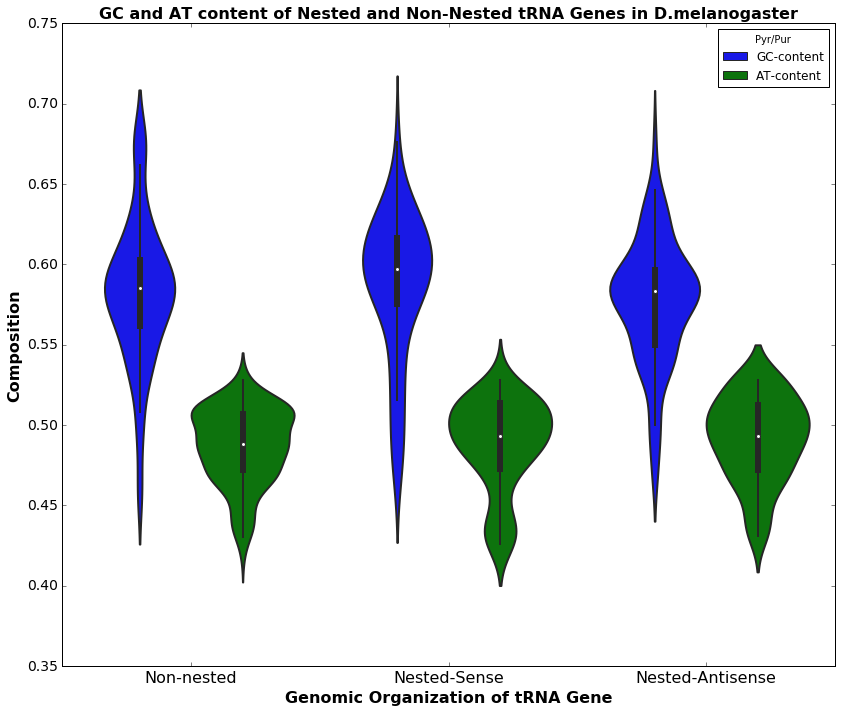

In [156]:
data=pd.melt(fb_trna,id_vars=['Co-orientation'],value_vars=['GC-content', 'AT-content'],
             var_name='Pyr/Pur')
plt.figure(figsize=(12,10))
#ax = seaborn.boxplot(x='Co-orientation',y='value',data=data,hue='Nucleotide/Base',width=0.8,linewidth=2)
viol = seaborn.violinplot(x='Co-orientation',y='value',data=data,hue='Pyr/Pur',width=0.8,linewidth=2,saturation=0.8)
plt.xticks(fontsize=16);plt.yticks(fontsize=14)
plt.ylabel('Composition',fontsize=16, fontweight='bold')
plt.xlabel('Genomic Organization of tRNA Gene',fontsize=16, fontweight='bold')
plt.title('GC and AT content of Nested and Non-Nested tRNA Genes in D.melanogaster',fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

#### plot disribution of lengths

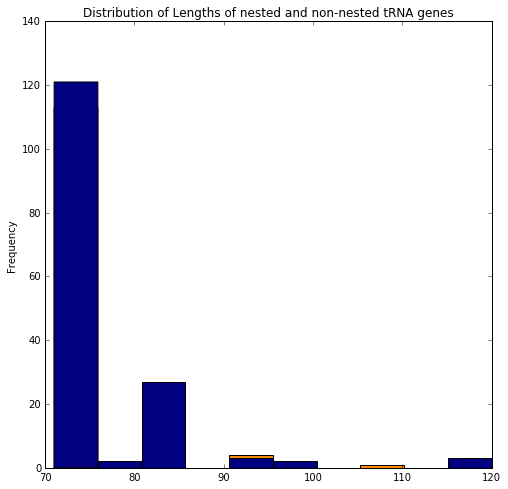

In [155]:
plt.figure(figsize=(8,8))
fb_trna[fb_trna['Organization']=='Nested']['Length'].plot.hist(color='darkorange')
fb_trna[fb_trna['Organization']=='Non-Nested']['Length'].plot.hist(color='navy')
plt.title('Distribution of Lengths of nested and non-nested tRNA genes')
plt.show()

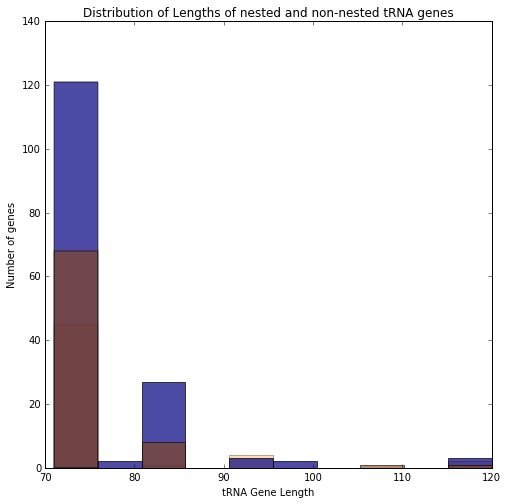

In [170]:
plt.figure(figsize=(8,8))
fb_trna[fb_trna['Co-orientation']=='Nested-Sense']['Length'].plot.hist(color='darkorange', alpha=0.3)
fb_trna[fb_trna['Co-orientation']=='Non-nested']['Length'].plot.hist(color='navy',alpha=0.7)
fb_trna[fb_trna['Co-orientation']=='Nested-Antisense']['Length'].plot.hist(color='saddlebrown',alpha=0.6)
plt.title('Distribution of Lengths of nested and non-nested tRNA genes')
plt.xlabel('tRNA Gene Length'); plt.ylabel('Number of genes')
plt.show()

#### the distributions of length are more or less similar between the groups

## Q3: Compare the composition of nested tRNAs and their host introns (I will extend to host protein-coding). Do nested genes reflect the composition of their host introns or just introns in general?

- I already have a bed file with only introns downloaded from ensemble, so I can use the bedtools getfasta with the entire drosophia genome.
- Go back to the Chang 2013 paper exploring on nested protein-coding genes to see their approach.For multi isoform host genes, Chang et al chose the longest isoform. 

In [188]:
import pyfaidx #allows indexing, retrieval, and in-place modification of FASTA files, similar to samtools -faidx option

In [190]:
## load the ensembl bed file with all introns
names = ['Chr', 'Start', 'End', 'ExonID', 'Score', 'Strand']
df_bed  = pd.read_table('dmel_introns_ensembl.bed', sep='\t', header=None, names=names) #import bed files with all introns
df_bed.head()

,Chr,Start,End,ExonID,Score,Strand
0,chr4,1037422,1037475,FBtr0333673_intron_0_0_chr4_1037423_r,0,-
1,chr4,1037569,1037645,FBtr0333673_intron_1_0_chr4_1037570_r,0,-
2,chr4,1037740,1038358,FBtr0333673_intron_2_0_chr4_1037741_r,0,-
3,chr4,1038434,1045155,FBtr0333673_intron_3_0_chr4_1038435_r,0,-
4,chr4,1045248,1047263,FBtr0333673_intron_4_0_chr4_1045249_r,0,-


In [192]:
import pickle

In [193]:
##import the saved dictionary object i made containing info on intron-nested trnas
with open('dmel_nested_trnas.txt', 'rb') as handle:
    host_introns= pickle.loads(handle.read())
host_introns['X']['FBgn0052493'] ## {chrom":{trna_id:[list of introns transcript ID]}}

['FBtr0344076_intron_1_0_chrX_3376234_f',
 'FBtr0344078_intron_2_0_chrX_3424293_r',
 'FBtr0332303_intron_2_0_chrX_3424293_r',
 'FBtr0070534_intron_2_0_chrX_3424293_r',
 'FBtr0332302_intron_2_0_chrX_3424293_r',
 'FBtr0332304_intron_2_0_chrX_3424293_r']

#### the above gene has 6 introns
there are multiple introns in some host genes but what I want is the specific host intron. I'll have to use the longest isoform for each parent protein-coding genes.   
-<i> I need to figure the nomenclature.. whate does intron_a_b_chr... mean? Is a the exon number then b the intron location</i>

In [200]:
merged[merged['Host_gene_name']=='EcR'].head(5)

,Chrom,Start,End,Strand,tRNA_ID,tRNA_name,Host_Exon_ID,intron_length,mRNA_length,Host_gene_name,Host_Gene_Strand,Co-orientation
15,2R,6166151,6166224,+,FBgn0011880,Ile-AAT-1-1-,FBtr0086008,16205,5108,EcR,-,No
16,2R,6165984,6166056,+,FBgn0011887,Lys-CTT-1-4-,FBtr0086008,16205,5108,EcR,-,No
17,2R,6164876,6164948,-,FBgn0011888,Lys-CTT-1-3-,FBtr0086008,16205,5108,EcR,-,Yes
18,2R,6162681,6162753,-,FBgn0011889,Lys-CTT-1-2-,FBtr0086008,16205,5108,EcR,-,Yes
19,2R,6142372,6142444,-,FBgn0011891,Lys-CTT-1-1-,FBtr0086008,170274,5108,EcR,-,Yes


FBtr0086008 is the longest isoform of ECR because in the intial stages of if identifying host genes, I stored the only topmost transcript ID since the others were redundant due the host gene having different isoforms

In [195]:
merged[merged['Host_gene_name']=='EcR'].shape

(13, 12)

In [198]:
merged[merged['Host_gene_name']=='mim']

,Chrom,Start,End,Strand,tRNA_ID,tRNA_name,Host_Exon_ID,intron_length,mRNA_length,Host_gene_name,Host_Gene_Strand,Co-orientation
36,2R,6946808,6946880,-,FBgn0011892,Lys-CTT-1-6-,FBtr0332942,323420,7918,mim,-,Yes
37,2R,6947738,6947810,-,FBgn0011893,Lys-CTT-1-7-,FBtr0332942,323420,7918,mim,-,Yes
38,2R,6948284,6948356,-,FBgn0011894,Lys-CTT-1-8-,FBtr0332942,323420,7918,mim,-,Yes
39,2R,6949133,6949205,-,FBgn0011895,Lys-CTT-1-9-,FBtr0332942,323420,7918,mim,-,Yes


In [197]:
host_introns['2R']['FBgn0011933']  ##QUERY the introns of trna gene on chromsome 2R

['FBtr0086008_intron_5_0_chr2R_6152551_r']

In [199]:
host_introns['2R']['FBgn0011893']

['FBtr0332942_intron_16_0_chr2R_6939344_r',
 'FBtr0302579_intron_13_0_chr2R_6939344_r',
 'FBtr0302034_intron_13_0_chr2R_6939344_r',
 'FBtr0306616_intron_15_0_chr2R_6939344_r',
 'FBtr0332941_intron_11_0_chr2R_6939344_r',
 'FBtr0306615_intron_15_0_chr2R_6939344_r',
 'FBtr0306614_intron_13_0_chr2R_6939344_r',
 'FBtr0302035_intron_10_0_chr2R_6939344_r',
 'FBtr0302578_intron_14_0_chr2R_6939344_r',
 'FBtr0332943_intron_13_0_chr2R_6939344_r',
 'FBtr0332944_intron_10_0_chr2R_6939344_r',
 'FBtr0113470_intron_13_0_chr2R_6939344_r',
 'FBtr0302577_intron_11_0_chr2R_6939344_r',
 'FBtr0332945_intron_2_0_chr2R_6945428_r']

### Interpretation  "FBtr0332942_intron_16_0_chr2R_6939344_r" : 
tRNA gene FBgn0011893 is nested in the 16th intron of the mim transcript FBtr0332942. Visually confirmed on Flybase's Gbrowse:
<img src='mim_intron.jpg'>

Since enxonIDs share the transcript ID with the introns query the original bed file to extract the coords of the known host introns then use that to extract the fasta sequence

In [202]:
df_bed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 152606 entries, 0 to 152605
Data columns (total 6 columns):
Chr       152606 non-null object
Start     152606 non-null int64
End       152606 non-null int64
ExonID    152606 non-null object
Score     152606 non-null int64
Strand    152606 non-null object
dtypes: int64(3), object(3)
memory usage: 7.0+ MB


In [205]:
df_bed.head()

,Chr,Start,End,ExonID,Score,Strand
0,chr4,1037422,1037475,FBtr0333673_intron_0_0_chr4_1037423_r,0,-
1,chr4,1037569,1037645,FBtr0333673_intron_1_0_chr4_1037570_r,0,-
2,chr4,1037740,1038358,FBtr0333673_intron_2_0_chr4_1037741_r,0,-
3,chr4,1038434,1045155,FBtr0333673_intron_3_0_chr4_1038435_r,0,-
4,chr4,1045248,1047263,FBtr0333673_intron_4_0_chr4_1045249_r,0,-


In [204]:
len('FBtr0332942')

11

In [217]:
##the exons Ids of the host introns I extracted and stored
host_IDs = merged['Host_Exon_ID'].values

host_bed = []  #stores the entries for the host_ID

for host in host_IDs:
    for i in range(df_bed.shape[0]):
        intron_ID = df_bed['ExonID'].values[i]
        if host in intron_ID:  ##query host exon ID against intron IDs in bed files 
            host_bed.append(df_bed[df_bed['ExonID']==intron_ID])
            break
    continue
host_bed

In [218]:
##concat
d = pd.concat(host_bed, axis=0)
d.info()  #should have 130 entries

<class 'pandas.core.frame.DataFrame'>
Int64Index: 130 entries, 91763 to 84134
Data columns (total 6 columns):
Chr       130 non-null object
Start     130 non-null int64
End       130 non-null int64
ExonID    130 non-null object
Score     130 non-null int64
Strand    130 non-null object
dtypes: int64(3), object(3)
memory usage: 7.1+ KB


In [219]:
d.head()

,Chr,Start,End,ExonID,Score,Strand
91763,chr3L,13229140,13238674,FBtr0305480_intron_0_0_chr3L_13229141_f,0,+
144394,chr3R,24545069,24551328,FBtr0084647_intron_0_0_chr3R_24545070_f,0,+
90342,chr3L,1344529,1344625,FBtr0310161_intron_0_0_chr3L_1344530_r,0,-
90342,chr3L,1344529,1344625,FBtr0310161_intron_0_0_chr3L_1344530_r,0,-
90342,chr3L,1344529,1344625,FBtr0310161_intron_0_0_chr3L_1344530_r,0,-


In [222]:
d['Length'] = d['Start']-d['End']
d['Length']=d['Length'].apply(np.abs)
d.head()

,Chr,Start,End,ExonID,Score,Strand,Length
91763,chr3L,13229140,13238674,FBtr0305480_intron_0_0_chr3L_13229141_f,0,+,9534
144394,chr3R,24545069,24551328,FBtr0084647_intron_0_0_chr3R_24545070_f,0,+,6259
90342,chr3L,1344529,1344625,FBtr0310161_intron_0_0_chr3L_1344530_r,0,-,96
90342,chr3L,1344529,1344625,FBtr0310161_intron_0_0_chr3L_1344530_r,0,-,96
90342,chr3L,1344529,1344625,FBtr0310161_intron_0_0_chr3L_1344530_r,0,-,96


In [225]:
##distibution of intron lengths
d.Length.describe()

count      130.000000
mean      4010.938462
std       7185.245053
min         54.000000
25%         63.000000
50%        194.000000
75%       5798.500000
max      39868.000000
Name: Length, dtype: float64

can't have a min less than 70 the smallest tRNA, gotta make sure I the introns matched the correct transcript

In [220]:
merged.head()

,Chrom,Start,End,Strand,tRNA_ID,tRNA_name,Host_Exon_ID,intron_length,mRNA_length,Host_gene_name,Host_Gene_Strand,Co-orientation
0,3L,13249547,13249618,+,FBgn0011844,sp-GTC-1-10-,FBtr0305480,49756,4841,caps,+,Yes
1,3R,24555302,24555373,+,FBgn0011845,sp-GTC-1-11-,FBtr0084647,1309,3120,Esyt2,+,Yes
2,3L,1397695,1397766,+,FBgn0011851,Glu-CTC-3-4-,FBtr0310161,204807,5167,Ptp61F,-,No
3,3L,1397932,1398003,+,FBgn0011852,Glu-CTC-3-5-,FBtr0310161,204807,5167,Ptp61F,-,No
4,3L,1398169,1398240,+,FBgn0011853,Glu-CTC-3-6-,FBtr0310161,204807,5167,Ptp61F,-,No


In [226]:
host_introns['X']['FBgn0052493']  

['FBtr0344076_intron_1_0_chrX_3376234_f',
 'FBtr0344078_intron_2_0_chrX_3424293_r',
 'FBtr0332303_intron_2_0_chrX_3424293_r',
 'FBtr0070534_intron_2_0_chrX_3424293_r',
 'FBtr0332302_intron_2_0_chrX_3424293_r',
 'FBtr0332304_intron_2_0_chrX_3424293_r']

In [229]:
chrom = list(host_introns.keys())

In [ ]:
trna_id = []
for c in chrom:
    trna_id.append(list(host_introns[c].keys()))
import itertools
trna_id = list(itertools.chain.from_iterable(trna_id))

In [252]:
for i in trna_id:
    if i not in merged['tRNA_ID'].values:
        print(i)

FBgn0052034


##### oh yeah this was the pseudo Thr that i dropped earlieronm

In [253]:
###however all the merged IDs showuld be in the dictionary
for i in merged['tRNA_ID'].values:
    if i not in trna_id :
        print(i)

### since I originally chose only the first intron of the host_intron dictionary, why use those values to query the original bed bed table 

In [244]:
###3 FOR LOOPS!!!
host_bed = []  #stores the entries for the host_ID
for c in chrom:
    for trna in list(host_introns[c].keys()):
        host_ID = host_introns[c][trna][0] #get the first intron_ID because that is what I stored
        for i in range(df_bed.shape[0]):
            intron_ID = df_bed['ExonID'].values[i]
            if host_ID == intron_ID:  ##query host exon ID against intron IDs in bed files 
                host_bed.append(df_bed[df_bed['ExonID']==intron_ID])
                break
        continue

In [245]:
a = pd.concat(host_bed, axis=0)
a['Length'] = a['Start']-a['End']
a['Length']=a['Length'].apply(np.abs)
a.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 131 entries, 144401 to 9568
Data columns (total 7 columns):
Chr       131 non-null object
Start     131 non-null int64
End       131 non-null int64
ExonID    131 non-null object
Score     131 non-null int64
Strand    131 non-null object
Length    131 non-null int64
dtypes: int64(4), object(3)
memory usage: 8.2+ KB


In [249]:
a.head()

,Chr,Start,End,ExonID,Score,Strand,Length
144401,chr3R,24555133,24555458,FBtr0084647_intron_7_0_chr3R_24555134_f,0,+,325
135484,chr3R,16315246,16321962,FBtr0334699_intron_7_0_chr3R_16315247_r,0,-,6716
123959,chr3R,5385862,5392786,FBtr0078800_intron_9_0_chr3R_5385863_r,0,-,6924
118231,chr3R,8842839,8864785,FBtr0305301_intron_10_0_chr3R_8842840_r,0,-,21946
129227,chr3R,10264878,10291099,FBtr0305356_intron_0_0_chr3R_10264879_f,0,+,26221


#### use these to get sequence from flybase
#### the intron FBtr0084647_intron_7_0_chr3R_24555134_f	starts at 24555134 (or 24555133 since bed is zero-count)


In [247]:
a.to_csv('host_introns_only.bed',sep=',',index=False)

as a sanity check against misaanottation of trna coords inside genes, I downloaded a fasta sequence with all introns of all the host genes and then search for tRNAs wirh trnacanse2.0

In [248]:
a.Length.describe()

count       131.000000
mean      22613.664122
std       31996.848344
min         214.000000
25%        5689.500000
50%       15043.000000
75%       21127.000000
max      126467.000000
Name: Length, dtype: float64

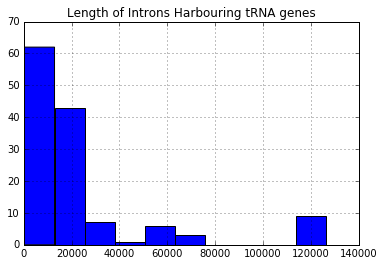

In [348]:
a.Length.hist()
plt.title('Length of Introns Harbouring tRNA genes')
plt.show()

### this is better

In [260]:
##get list of host transcript ids to downloand inton sequence
with open('host_transcript_ids.txt','w+') as f:
    for ID in merged['Host_Exon_ID'].values:
        f.write(ID+'\n')

### load trnascan results from the intronic sequences of host genes

In [266]:
tscan = pd.read_table('tscan_predicted_from_host_introns.txt',sep='\t',skiprows=1).reset_index()
tscan.head()
##begin.1 == intron begin

,index,Name,tRNA #,Begin,End,Type,Codon,Begin.1,End,Score,CM,Score.1,Note
0,0,--------,------,-----,------,----,-----,-----,----,------,-------,-------,------
1,1,FBgn0034091_intron_FBgn0034091:12_FBgn0034091:7,1,2484,2555,Gln,CTG,0,0,71.5,Gln,112.1,NaN
2,2,FBgn0262867_intron_FBgn0262867:12_FBgn0262867:11,1,5450,5523,Asn,GTT,0,0,84.7,Asn,118.8,NaN
3,3,FBgn0262867_intron_FBgn0262867:12_FBgn0262867:11,2,5280,5207,Asn,GTT,0,0,84.7,Asn,118.8,NaN
4,4,FBgn0052521_intron_FBgn0052521:11_FBgn0052521:8,1,49646,49722,Ile,AAT,0,0,44.3,Ile,55.3,pseudo


In [267]:
tscan.Note.value_counts()  ##drop pseudogenes

pseudo    6
------    1
Name: Note, dtype: int64

In [268]:
tscan=tscan[tscan['Note']!='pseudo'].drop('Note',axis=1)
tscan.head()

,index,Name,tRNA #,Begin,End,Type,Codon,Begin.1,End,Score,CM,Score.1
0,0,--------,------,-----,------,----,-----,-----,----,------,-------,-------
1,1,FBgn0034091_intron_FBgn0034091:12_FBgn0034091:7,1,2484,2555,Gln,CTG,0,0,71.5,Gln,112.1
2,2,FBgn0262867_intron_FBgn0262867:12_FBgn0262867:11,1,5450,5523,Asn,GTT,0,0,84.7,Asn,118.8
3,3,FBgn0262867_intron_FBgn0262867:12_FBgn0262867:11,2,5280,5207,Asn,GTT,0,0,84.7,Asn,118.8
5,5,FBgn0052521_intron_FBgn0052521:11_FBgn0052521:8,2,48955,48883,Arg,TCG,0,0,70.8,Arg,102.4


In [279]:
tscan = tscan.drop(0).drop('index',axis=1)

In [281]:
tscan['Score'] = tscan['Score'].astype(float)
tscan = tscan[tscan['Score']>50]  ##keep covariance score above 50
tscan.describe()

,Score
count,212.000000
mean,75.840094
std,7.598749
min,56.000000
25%,71.500000
50%,75.800000
75%,81.700000
max,88.800000


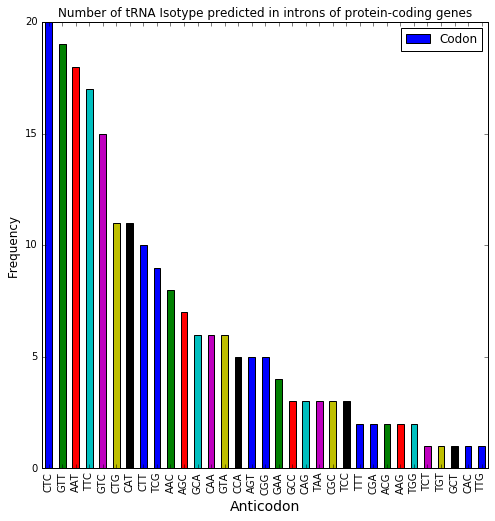

In [286]:
tscan.Codon.value_counts().to_frame().reset_index().plot.bar('index',0, figsize=(8,8))
plt.xlabel('Anticodon',fontsize=14);plt.ylabel('Frequency',fontsize=12)
plt.title('Number of tRNA Isotype predicted in introns of protein-coding genes')
plt.show()

tRNAScanse predicted 212 high-confident tRNAs from the introns of the host genes, that is more than 130. I don't know what this means. However, not to be side-tracked I still haven't answered the relationship of nucleotide composition between nested tRNAs and their host introns

### fasta sequences were parsed and extracted in another notebook

In [287]:
merged = pd.read_table('trna_host_genes_merged.csv', sep=',')#only nested trnas updated with intron-seqs

In [288]:
merged.head()

,Chrom,Start,End,Strand,tRNA_ID,tRNA_name,Host_Exon_ID,intron_length,mRNA_length,Host_gene_name,Host_Gene_Strand,Co-orientation,Intron_Sequence
0,2R,21181284,21181355,+,FBgn0053539,Trp-CCA-2-5-,FBtr0071578,3816,1625,Pu,+,Yes,GTAAGCACACCACACATTTCAAGCAATTAGCACCGGGTCAGTGATC...
1,3L,3096891,3096963,-,FBgn0052272,Lys-CTT-1-13-,FBtr0073124,2776,3953,Cht7,-,Yes,GTAAGTAAAAAATGTAAAAAGAAATTAAACATGAACAAGTAATTGG...
2,3L,3097519,3097590,+,FBgn0052286,Cys-GCA-1-4-,FBtr0073124,2776,3953,Cht7,-,No,GTAAGTAAAAAATGTAAAAAGAAATTAAACATGAACAAGTAATTGG...
3,3L,3096369,3096440,+,FBgn0052287,Cys-GCA-1-3-,FBtr0073124,2776,3953,Cht7,-,No,GTAAGTAAAAAATGTAAAAAGAAATTAAACATGAACAAGTAATTGG...
4,3L,3095737,3095808,+,FBgn0052288,Cys-GCA-1-1-,FBtr0073124,2776,3953,Cht7,-,No,GTAAGTAAAAAATGTAAAAAGAAATTAAACATGAACAAGTAATTGG...


### compute nucleotide composition of host introns 

In [291]:
for base in ['A','G','T','C']:
    merged['{}-content'.format(base)] = base_comp(merged['Intron_Sequence'].values,base)
merged.head()

,Chrom,Start,End,Strand,tRNA_ID,tRNA_name,Host_Exon_ID,intron_length,mRNA_length,Host_gene_name,Host_Gene_Strand,Co-orientation,Intron_Sequence,A-content,G-content,T-content,C-content
0,2R,21181284,21181355,+,FBgn0053539,Trp-CCA-2-5-,FBtr0071578,3816,1625,Pu,+,Yes,GTAAGCACACCACACATTTCAAGCAATTAGCACCGGGTCAGTGATC...,0.278302,0.225629,0.259434,0.236635
1,3L,3096891,3096963,-,FBgn0052272,Lys-CTT-1-13-,FBtr0073124,2776,3953,Cht7,-,Yes,GTAAGTAAAAAATGTAAAAAGAAATTAAACATGAACAAGTAATTGG...,0.333934,0.195605,0.279179,0.191282
2,3L,3097519,3097590,+,FBgn0052286,Cys-GCA-1-4-,FBtr0073124,2776,3953,Cht7,-,No,GTAAGTAAAAAATGTAAAAAGAAATTAAACATGAACAAGTAATTGG...,0.333934,0.195605,0.279179,0.191282
3,3L,3096369,3096440,+,FBgn0052287,Cys-GCA-1-3-,FBtr0073124,2776,3953,Cht7,-,No,GTAAGTAAAAAATGTAAAAAGAAATTAAACATGAACAAGTAATTGG...,0.333934,0.195605,0.279179,0.191282
4,3L,3095737,3095808,+,FBgn0052288,Cys-GCA-1-1-,FBtr0073124,2776,3953,Cht7,-,No,GTAAGTAAAAAATGTAAAAAGAAATTAAACATGAACAAGTAATTGG...,0.333934,0.195605,0.279179,0.191282


In [292]:
l=[]
for seq in merged['Intron_Sequence'].values:
    l.append(len(seq))
merged['intron_length']=l

In [293]:
merged.head()

,Chrom,Start,End,Strand,tRNA_ID,tRNA_name,Host_Exon_ID,intron_length,mRNA_length,Host_gene_name,Host_Gene_Strand,Co-orientation,Intron_Sequence,A-content,G-content,T-content,C-content
0,2R,21181284,21181355,+,FBgn0053539,Trp-CCA-2-5-,FBtr0071578,1272,1625,Pu,+,Yes,GTAAGCACACCACACATTTCAAGCAATTAGCACCGGGTCAGTGATC...,0.278302,0.225629,0.259434,0.236635
1,3L,3096891,3096963,-,FBgn0052272,Lys-CTT-1-13-,FBtr0073124,2776,3953,Cht7,-,Yes,GTAAGTAAAAAATGTAAAAAGAAATTAAACATGAACAAGTAATTGG...,0.333934,0.195605,0.279179,0.191282
2,3L,3097519,3097590,+,FBgn0052286,Cys-GCA-1-4-,FBtr0073124,2776,3953,Cht7,-,No,GTAAGTAAAAAATGTAAAAAGAAATTAAACATGAACAAGTAATTGG...,0.333934,0.195605,0.279179,0.191282
3,3L,3096369,3096440,+,FBgn0052287,Cys-GCA-1-3-,FBtr0073124,2776,3953,Cht7,-,No,GTAAGTAAAAAATGTAAAAAGAAATTAAACATGAACAAGTAATTGG...,0.333934,0.195605,0.279179,0.191282
4,3L,3095737,3095808,+,FBgn0052288,Cys-GCA-1-1-,FBtr0073124,2776,3953,Cht7,-,No,GTAAGTAAAAAATGTAAAAAGAAATTAAACATGAACAAGTAATTGG...,0.333934,0.195605,0.279179,0.191282


In [294]:
merged.to_csv('trna_host_genes_merged.csv', sep=',',index=False)#only nested trnas 

In [295]:
merged['intron_length'].describe()

count       130.000000
mean      22784.223077
std       32060.791424
min         214.000000
25%        5810.500000
50%       15043.000000
75%       21536.500000
max      126467.000000
Name: intron_length, dtype: float64

In [296]:
data=pd.melt(merged,id_vars=['Co-orientation'],value_vars=['A-content', 'G-content', 'C-content','T-content'],
             var_name='Nucleotide/Base')
data.head()

,Co-orientation,Nucleotide/Base,value
0,Yes,A-content,0.278302
1,Yes,A-content,0.333934
2,No,A-content,0.333934
3,No,A-content,0.333934
4,No,A-content,0.333934


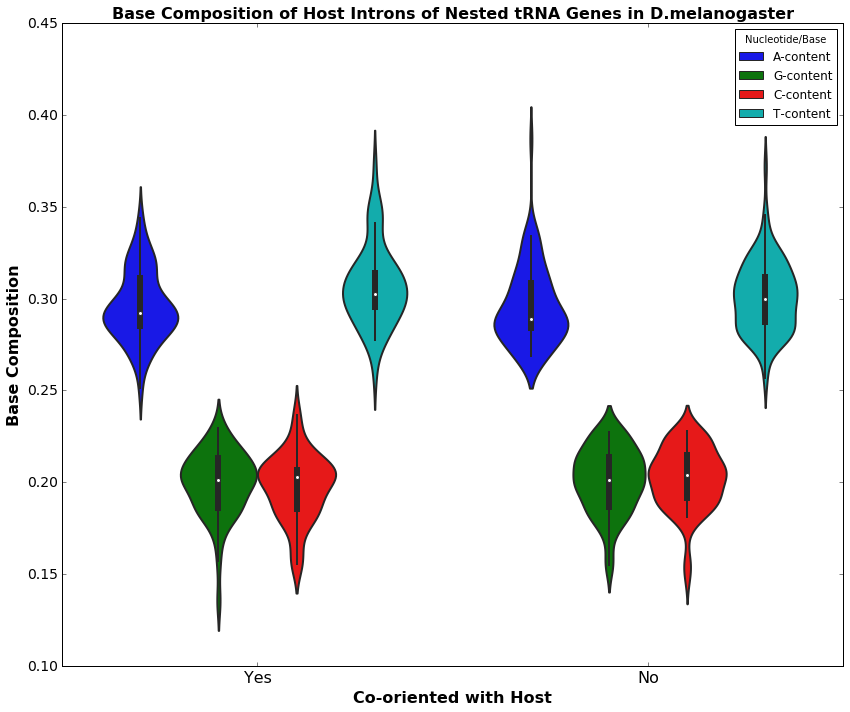

In [298]:
plt.figure(figsize=(12,10))
#ax = seaborn.boxplot(x='Co-orientation',y='value',data=data,hue='Nucleotide/Base',width=0.8,linewidth=2)
viol = seaborn.violinplot(x='Co-orientation',y='value',data=data,
                          hue='Nucleotide/Base',width=0.8,linewidth=2,saturation=0.8)
plt.xticks(fontsize=16);plt.yticks(fontsize=14)
plt.ylabel('Base Composition',fontsize=16, fontweight='bold')
plt.xlabel('Co-oriented with Host',fontsize=16, fontweight='bold')
plt.title('Base Composition of Host Introns of Nested tRNA Genes in D.melanogaster',fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

### The tRNAs show an overal GC-bias but he introns show an AT-bias
try plot both host and nested on same boxplot

In [299]:
fb_trna.head()

,Flybase_ID,Fb_symbol,Chromosome,Start,End,Sequence,Complement,Amino_acid,Organization,A-content,G-content,C-content,T-content,GC-content,AT-content,Length,Co-orientation
0,FBgn0011840,Ala-AGC-2-3,3R,17620144,17620216,GGGGAUGUAGCUCAGAUGGUAGAGCGCUCGCUUAGCAUGUGAGAGG...,True,Glu,Non-Nested,0.205479,0.356164,0.232877,0.205479,0.589041,0.438356,73,Non-nested
1,FBgn0011844,Asp-GTC-1-10,3L,13249547,13249618,UCCUCGAUAGUAUAGUGGUUAGUAUCCCCGCCUGUCACGCGGGAGA...,False,Lys,Nested,0.166667,0.319444,0.277778,0.236111,0.597222,0.513889,72,Nested-Sense
2,FBgn0011845,Asp-GTC-1-11,3R,24555302,24555373,UCCUCGAUAGUAUAGUGGUUAGUAUCCCCGCCUGUCACGCGGGAGA...,False,Gly,Nested,0.166667,0.319444,0.277778,0.236111,0.597222,0.513889,72,Nested-Sense
3,FBgn0011848,Glu-TTC-1-6,2R,19727981,19728052,UCCCAUAUGGUCUAGUGGCUAGGAUAUCUGGCUUUCACCCAGAAGG...,True,Gly,Non-Nested,0.194444,0.291667,0.250000,0.263889,0.541667,0.513889,72,Non-nested
4,FBgn0011849,Glu-TTC-1-5,2R,19727460,19727531,UCCCAUAUGGUCUAGUGGCUAGGAUAUCUGGCUUUCACCCAGAAGG...,True,Phe,Non-Nested,0.194444,0.291667,0.250000,0.263889,0.541667,0.513889,72,Non-nested


### append the information for nested genes to thenested genes specific table

In [300]:
nest = fb_trna[fb_trna['Organization']=='Nested'].sort_values(by='Flybase_ID')
merged = merged.sort_values(by='tRNA_ID')

In [301]:
nest.head()

,Flybase_ID,Fb_symbol,Chromosome,Start,End,Sequence,Complement,Amino_acid,Organization,A-content,G-content,C-content,T-content,GC-content,AT-content,Length,Co-orientation
1,FBgn0011844,Asp-GTC-1-10,3L,13249547,13249618,UCCUCGAUAGUAUAGUGGUUAGUAUCCCCGCCUGUCACGCGGGAGA...,False,Lys,Nested,0.166667,0.319444,0.277778,0.236111,0.597222,0.513889,72,Nested-Sense
2,FBgn0011845,Asp-GTC-1-11,3R,24555302,24555373,UCCUCGAUAGUAUAGUGGUUAGUAUCCCCGCCUGUCACGCGGGAGA...,False,Gly,Nested,0.166667,0.319444,0.277778,0.236111,0.597222,0.513889,72,Nested-Sense
6,FBgn0011851,Glu-CTC-3-4,3L,1397695,1397766,UCCCAUAUUGUCUAGUGGUUAGGAUAUCCGGCUCUCACCCGGAAGG...,False,Leu,Nested,0.194444,0.277778,0.263889,0.263889,0.541667,0.527778,72,Nested-Antisense
7,FBgn0011852,Glu-CTC-3-5,3L,1397932,1398003,UCCCAUAUUGUCUAGUGGUUAGGAUAUCCGGCUCUCACCCGGAAGG...,False,Ile,Nested,0.194444,0.277778,0.263889,0.263889,0.541667,0.527778,72,Nested-Antisense
8,FBgn0011853,Glu-CTC-3-6,3L,1398169,1398240,UCCCAUAUUGUCUAGUGGUUAGGAUAUCCGGCUCUCACCCGGAAGG...,False,Gln,Nested,0.194444,0.277778,0.263889,0.263889,0.541667,0.527778,72,Nested-Antisense


In [302]:
merged.head()

,Chrom,Start,End,Strand,tRNA_ID,tRNA_name,Host_Exon_ID,intron_length,mRNA_length,Host_gene_name,Host_Gene_Strand,Co-orientation,Intron_Sequence,A-content,G-content,T-content,C-content
80,3L,13249547,13249618,+,FBgn0011844,sp-GTC-1-10-,FBtr0305480,12439,4841,caps,+,Yes,GTAAGTTCAGACCCGATACTCAATTCCACTCCAATTCCCAGCCATC...,0.282901,0.208779,0.291181,0.217140
26,3R,24555302,24555373,+,FBgn0011845,sp-GTC-1-11-,FBtr0084647,325,3120,Esyt2,+,Yes,GTGAGTTCAGTTTTCCACAACTCAACGATAAACTTGCAGAATTACG...,0.286154,0.172308,0.350769,0.190769
96,3L,1397695,1397766,+,FBgn0011851,Glu-CTC-3-4-,FBtr0310161,126467,5167,Ptp61F,-,No,GTAAGTGAGCAAGCAATGTTATAGTTATAGCCGGGCTAATCTGATT...,0.268979,0.226012,0.280136,0.224873
93,3L,1397932,1398003,+,FBgn0011852,Glu-CTC-3-5-,FBtr0310161,126467,5167,Ptp61F,-,No,GTAAGTGAGCAAGCAATGTTATAGTTATAGCCGGGCTAATCTGATT...,0.268979,0.226012,0.280136,0.224873
92,3L,1398169,1398240,+,FBgn0011853,Glu-CTC-3-6-,FBtr0310161,126467,5167,Ptp61F,-,No,GTAAGTGAGCAAGCAATGTTATAGTTATAGCCGGGCTAATCTGATT...,0.268979,0.226012,0.280136,0.224873


In [303]:
merged['tRNA_ID'].values == nest['Flybase_ID'].values

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [304]:
merged['tRNA_Sequence']=nest['Sequence'].values
for base in ['A','G','T','C']:
    merged['{}-content_trna'.format(base)] = nest['{}-content'.format(base)].values
merged.head()

,Chrom,Start,End,Strand,tRNA_ID,tRNA_name,Host_Exon_ID,intron_length,mRNA_length,Host_gene_name,...,Intron_Sequence,A-content,G-content,T-content,C-content,tRNA_Sequence,A-content_trna,G-content_trna,T-content_trna,C-content_trna
80,3L,13249547,13249618,+,FBgn0011844,sp-GTC-1-10-,FBtr0305480,12439,4841,caps,...,GTAAGTTCAGACCCGATACTCAATTCCACTCCAATTCCCAGCCATC...,0.282901,0.208779,0.291181,0.217140,UCCUCGAUAGUAUAGUGGUUAGUAUCCCCGCCUGUCACGCGGGAGA...,0.166667,0.319444,0.236111,0.277778
26,3R,24555302,24555373,+,FBgn0011845,sp-GTC-1-11-,FBtr0084647,325,3120,Esyt2,...,GTGAGTTCAGTTTTCCACAACTCAACGATAAACTTGCAGAATTACG...,0.286154,0.172308,0.350769,0.190769,UCCUCGAUAGUAUAGUGGUUAGUAUCCCCGCCUGUCACGCGGGAGA...,0.166667,0.319444,0.236111,0.277778
96,3L,1397695,1397766,+,FBgn0011851,Glu-CTC-3-4-,FBtr0310161,126467,5167,Ptp61F,...,GTAAGTGAGCAAGCAATGTTATAGTTATAGCCGGGCTAATCTGATT...,0.268979,0.226012,0.280136,0.224873,UCCCAUAUUGUCUAGUGGUUAGGAUAUCCGGCUCUCACCCGGAAGG...,0.194444,0.277778,0.263889,0.263889
93,3L,1397932,1398003,+,FBgn0011852,Glu-CTC-3-5-,FBtr0310161,126467,5167,Ptp61F,...,GTAAGTGAGCAAGCAATGTTATAGTTATAGCCGGGCTAATCTGATT...,0.268979,0.226012,0.280136,0.224873,UCCCAUAUUGUCUAGUGGUUAGGAUAUCCGGCUCUCACCCGGAAGG...,0.194444,0.277778,0.263889,0.263889
92,3L,1398169,1398240,+,FBgn0011853,Glu-CTC-3-6-,FBtr0310161,126467,5167,Ptp61F,...,GTAAGTGAGCAAGCAATGTTATAGTTATAGCCGGGCTAATCTGATT...,0.268979,0.226012,0.280136,0.224873,UCCCAUAUUGUCUAGUGGUUAGGAUAUCCGGCUCUCACCCGGAAGG...,0.194444,0.277778,0.263889,0.263889


In [305]:
merged.to_csv('trna_host_genes_merged.csv', sep=',',index=False)#only nested trnas 

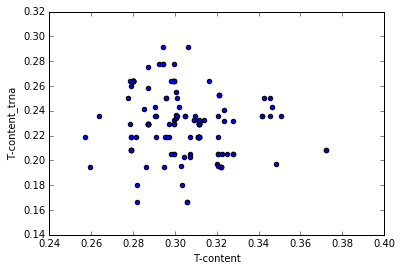

In [308]:
merged.plot.scatter('T-content','T-content_trna') #intron vs their nested trna
plt.show()

In [309]:
from scipy.stats import pearsonr,spearmanr

In [312]:
for base in ['A','G','T','C']:
    print("Correlation between {}-content of host intron and nested tRNA: \n".format(base),
          spearmanr(merged['{}-content'.format(base)].values, 
                    merged['{}-content_trna'.format(base)].values))

Correlation between A-content of host intron and nested tRNA: 
 SpearmanrResult(correlation=-0.22386806717211127, pvalue=0.010454592273999388)
Correlation between G-content of host intron and nested tRNA: 
 SpearmanrResult(correlation=-0.30460484529983234, pvalue=0.00042572078601086597)
Correlation between T-content of host intron and nested tRNA: 
 SpearmanrResult(correlation=-0.20132806986186438, pvalue=0.021624795352922076)
Correlation between C-content of host intron and nested tRNA: 
 SpearmanrResult(correlation=-0.08216356156869041, pvalue=0.3527163445729943)


In [313]:
merged['GC-content_trna'] = merged['G-content_trna']+merged['C-content_trna']
merged['GC-content_intron']= merged['G-content']+merged['C-content']

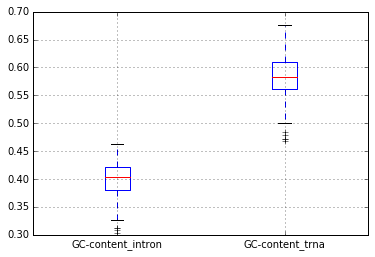

In [318]:
merged[['GC-content_intron','GC-content_trna']].boxplot()
plt.show()

In [319]:
merged['AT-content_trna'] = merged['A-content_trna']+merged['T-content_trna']
merged['AT-content_intron']= merged['T-content']+merged['T-content']

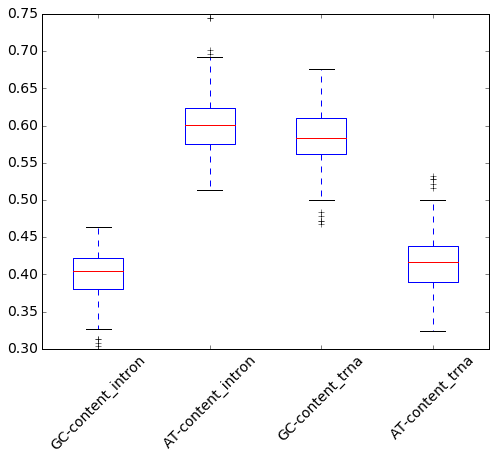

In [345]:
plt.figure(figsize=(8,6))
merged[['GC-content_intron','AT-content_intron','GC-content_trna',
        'AT-content_trna']].boxplot(grid=False,fontsize=14,rot=45)
plt.show()

In [336]:
###lets see if the same based on sense or antisense
anti = merged[merged['Co-orientation']=='No']
sense=merged[merged['Co-orientation']=='Yes']

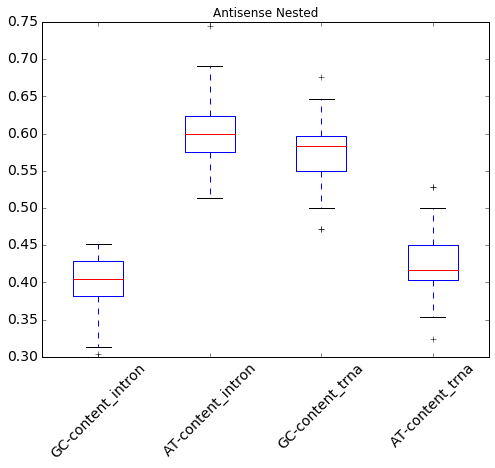

In [344]:
plt.figure(figsize=(8,6))
anti[['GC-content_intron','AT-content_intron','GC-content_trna',
        'AT-content_trna']].boxplot(grid=False,fontsize=14,rot=45)
plt.title('Antisense Nested')
plt.show()

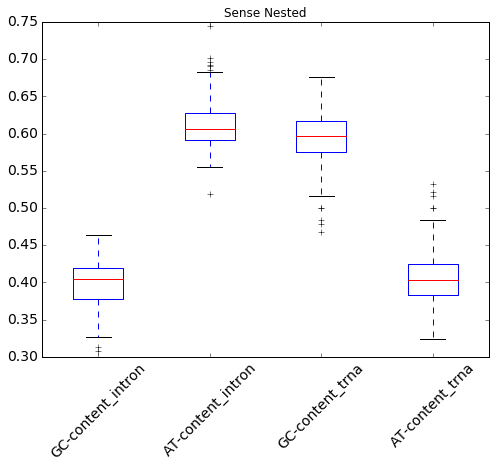

In [343]:
plt.figure(figsize=(8,6))
sense[['GC-content_intron','AT-content_intron','GC-content_trna',
        'AT-content_trna']].boxplot(grid=False,fontsize=14,rot=45)
plt.title('Sense Nested')
plt.show()

#### GC-rich tRNA genes are nested inside AT-rich introns, regardless of trna orienting sense or antisense to host intron

In [333]:
merged['intron_length'].quantile(0.9)

56971.400000000016

In [335]:
merged['intron_length'].max()

126467

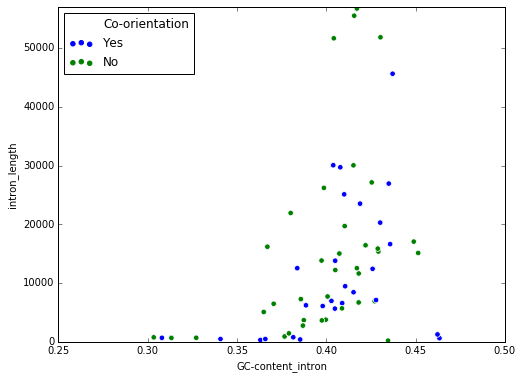

In [375]:
##do we see a difference in relationship to lenght and GC based on orientation
plt.figure(figsize=(8,6))
seaborn.scatterplot(x = 'GC-content_intron',y='intron_length', data=merged, hue='Co-orientation',
                   s=30) #
plt.legend(loc='upper left')
plt.ylim(0.0,57000)
plt.show()

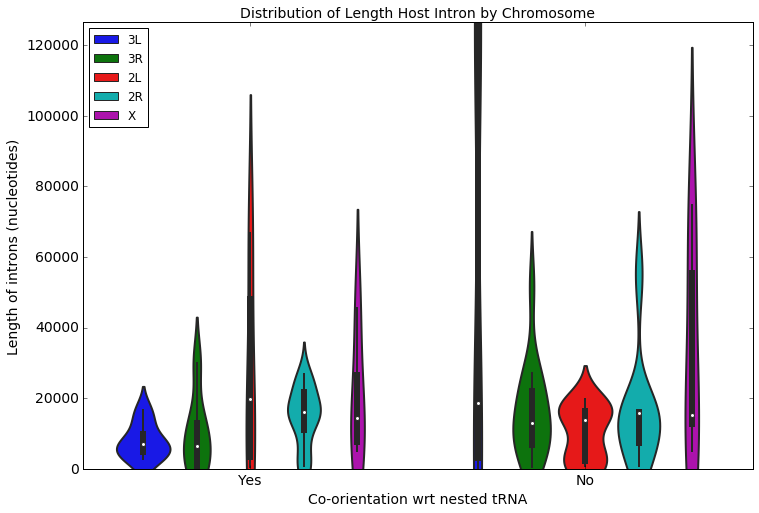

In [378]:
plt.figure(figsize=(12,8))
seaborn.violinplot(x='Co-orientation',y='intron_length',data=merged,
                          hue='Chrom',width=0.8,linewidth=2,saturation=0.8)
plt.legend(loc='upper left')
plt.ylim(0,merged['intron_length'].max())
plt.ylabel('Length of introns (nucleotides)', fontsize=14);plt.yticks(fontsize=14)
plt.xlabel('Co-orientation wrt nested tRNA', fontsize=14);plt.xticks(fontsize=14)
plt.title('Distribution of Length Host Intron by Chromosome',fontsize=14)
plt.show()

#### do a log transform for better visualization. the range of intron length is wide 214bp to 120k bp

In [396]:
merged['log_intron_length']=merged['intron_length'].apply(np.log)

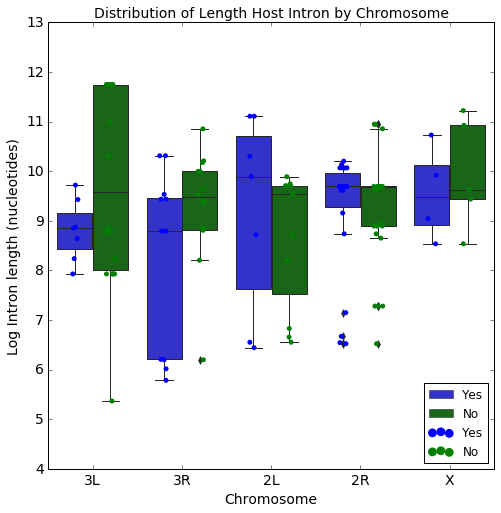

In [400]:
plt.figure(figsize=(8,8))
ax = seaborn.boxplot(x='Chrom',y='log_intron_length',data=merged,
                          hue='Co-orientation', saturation=0.6)
ax = seaborn.stripplot(x='Chrom',y='log_intron_length',data=merged,
                          hue='Co-orientation',jitter=True,dodge=True, edgecolor='red')
plt.legend(loc='lower right')
#plt.ylim(0,merged['intron_length'].max())
plt.ylabel('Log Intron length (nucleotides)', fontsize=14);plt.yticks(fontsize=14)
plt.xlabel('Chromosome', fontsize=14);plt.xticks(fontsize=14)
plt.title('Distribution of Length Host Intron by Chromosome',fontsize=14)
plt.show()

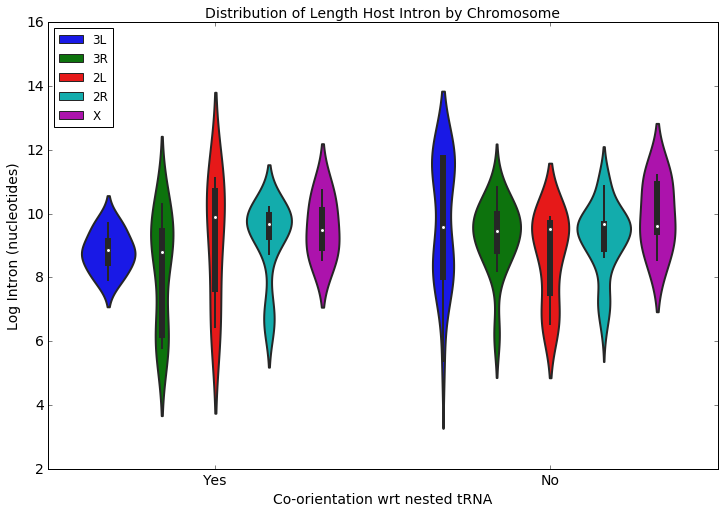

In [402]:
plt.figure(figsize=(12,8))
seaborn.violinplot(x='Co-orientation',y='log_intron_length',data=merged,
                          hue='Chrom',width=0.8,linewidth=2,saturation=0.8)
plt.legend(loc='upper left')
#plt.ylim(0,merged['intron_length'].max())
plt.ylabel('Log Intron (nucleotides)', fontsize=14);plt.yticks(fontsize=14)
plt.xlabel('Co-orientation wrt nested tRNA', fontsize=14);plt.xticks(fontsize=14)
plt.title('Distribution of Length Host Intron by Chromosome',fontsize=14)
plt.show()

Maayan (*'Differential GC Content between Exonsand Introns Establishes Distinct Strategies of Splice-Site Recognition*, 2013) showed that the GC-content of exons inversely correlates with the length of flanking introns in veterbrate genomes

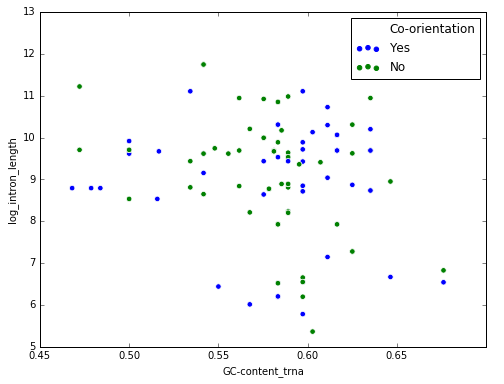

In [406]:
plt.figure(figsize=(8,6))
seaborn.scatterplot(x = 'GC-content_trna',y='log_intron_length', data=merged, hue='Co-orientation',
                   s=30) #
plt.legend(loc='upper right')
#plt.ylim(0.0,57000)
plt.show()

# Compare the host intron with other intronswithin same  genes, see host_introns_trnaseqs notebook